In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kbtu-ml-2022-image-classification/meta
/kaggle/input/kbtu-ml-2022-image-classification/data_train
/kaggle/input/kbtu-ml-2022-image-classification/data_test


## Modern Convolutional Neural Networks


### Description

In this homework, you need to write a convolutional neural network for image classification.

You have been provided with a modified dataset of The Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)). It contains 50 thousand (train) + 25 thousand (test) 32x32 RGB images with numbers cut from real photos of house numbers.

Task: use convolutional neural networks to achieve maximum classification accuracy.

In this homework task, there are no restrictions on the architecture of the model, but you **need to implement it in PyTorch by yourself** and train it from scratch only on this dataset, without external data.

### Data

This notebook already has the code for PyTorch responsible for loading the data. The following is a brief description of the data storage format.

Each of the files is a `pickle` serialized with protocol version 4 (which became the default version in Python 3.8 and later) a python dictionary.

List of files:

- `meta` - dataset metadata (for example, class names)
- `data_train` - training data, 50K objects
- `data_test` - data for the test, 25K objects, without the correct classes

Data dictionaries have the following fields:

- `section` — name of the data part (train/test)
- `labels` - ground-truth classes, list of `N` numbers from 0 to 9
- `images` - numpy array of size `(N, 32, 32, 3)` with images

### Grade

The quality of the solution will be evaluated by the metric accuracy. Accuracy is the number of correctly classified pictures to the total number of pictures in the test set. The public leaderboard is calculated using 30% of the test data, so try not to retrain for it.

```
accuracy = (correct classified) / (total number of examples)
```

As a solution, you should send a file of the format:

```
ID,Category
0, 3
1, 2
2, 9
3, 1
...
```

where:

- `Id` — number of the object in the test dataset
- `Category` — predicted object class

This notebook already has the code that prepares the solution file.

### Experiments

Since there are so many different hyperparameters in training a neural network model, many different experiments will need to be done in this task. And it will be very useful, both for you and for us, who check, the presence of a text description of all, or at least the most interesting/important in choosing the final model, experiments with the results in the final notebook. The presence and detail of the description of the experiments will be included in the final grade for the homework. The deadline on Kaggle is specially set a little earlier so that you have time to calmly finish the report on the experiments.

## Baseline solution

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [5]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as T

The data is in the [Data](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition/data) section of the kaggle competition. <br>
You need to download the archive with the data and unzip it. <br>
In the variable below, specify the path to the dataset. <br>

In [7]:
dataset_root = "/kaggle/input/kbtu-ml-2022-image-classification"

Code for loading the modified SVHN dataset. Initialization Arguments:

- `root` — string, path to directory with dataset files
- `is_train` — flag, load part for training or test
- `transform` — image transformations
- `target_transform` — image class transformations

In [8]:
class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Dataset download

In [9]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=ToTensor(),
)

# Analysis

### Distribution of values is uneven, if a model will perfor poorly, I'll apply downsampling

In [10]:
targets = [data[i][1].item() for i in range(len(data))]
df = pd.DataFrame(targets)
df.value_counts()

1    9650
2    7595
3    5625
4    4941
5    4604
7    3876
6    3859
0    3341
8    3332
9    3177
dtype: int64

### Images have "fake" noise, namely 1s and 0s are randomly inserted

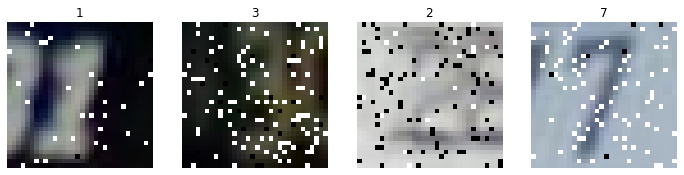

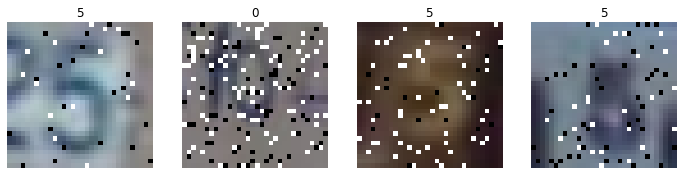

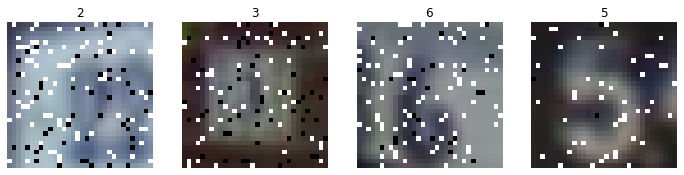

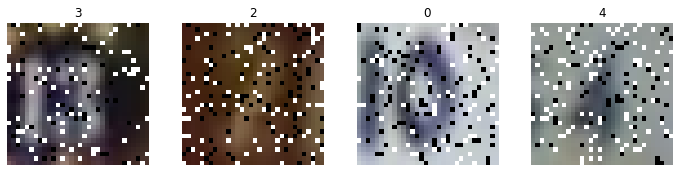

In [11]:
batch_size = 4
analysis_dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

it = iter(analysis_dataloader)

cols = 4
for rows in range(1, 5):
    imgs, labels = next(it)
    
    figure = plt.figure(figsize=(12, 12))
    
    i = 1
    for img, label in zip(imgs, labels):
        figure.add_subplot(rows, cols, i)
        i += 1
        plt.title(label.item())
        plt.axis("off")
        plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))

plt.show()

Let's see tensor's values and assure ourself that noise is indeed 1 and 0.

Below is the tensor for 3rd image, which is primaraly white, yet there are some anomalical values like `0.0000` and `1.0000`. However, values `0.0000` and `1.0000` could be real if they're surrounded by simmilar values.

tensor([[0.6902, 0.7059, 0.6941,  ..., 0.7294, 0.7490, 0.7686],
        [0.7647, 0.7647, 0.7451,  ..., 0.7294, 0.7412, 1.0000],
        [0.7647, 0.7451, 0.7216,  ..., 0.7412, 0.7529, 0.7608],
        ...,
        [1.0000, 0.7765, 0.7804,  ..., 0.7686, 0.7725, 0.7686],
        [0.7608, 0.7765, 0.7843,  ..., 0.7725, 0.7725, 1.0000],
        [0.7725, 0.7804, 0.7765,  ..., 0.7765, 0.7725, 0.7804]])


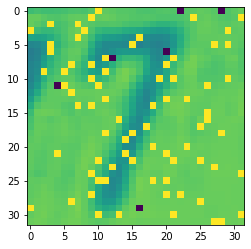

In [12]:
print(data[3][0][2])

plt.imshow(data[3][0][2]);

Blurring might solve it

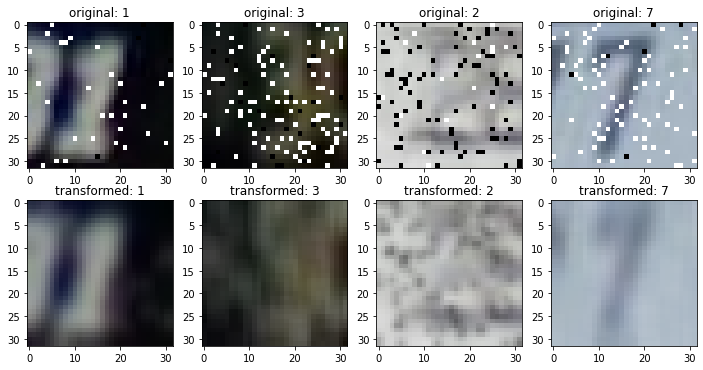

In [13]:
blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
blurred_imgs = [blurrer(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(blurred_imgs):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

### Lambda for removing noise

In [14]:
def remove_noise(data):
    for j in range(len(data)): # chanel iterator
        for k in range(len(data[0])): # row iterator
            for m in range(len(data[0][0])):
                if k !=0 and m !=0 and k != len(data[0]) - 1 and m != len(data[0][0]) - 1:
                    if data[j][k][m] == 0 or data[j][k][m] == 1:
                        data[j][k][m] = (data[j][k-1][m-1] + data[j][k+1][m+1] + data[j][k][m-1] + data[j][k][m+1]) / 4
    return data

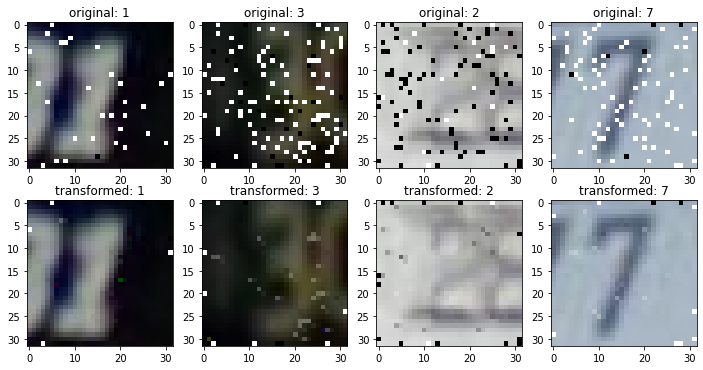

In [15]:
noise_removal = T.Lambda(remove_noise)
noiseless_imgs = [noise_removal(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(noiseless_imgs):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

### Crop

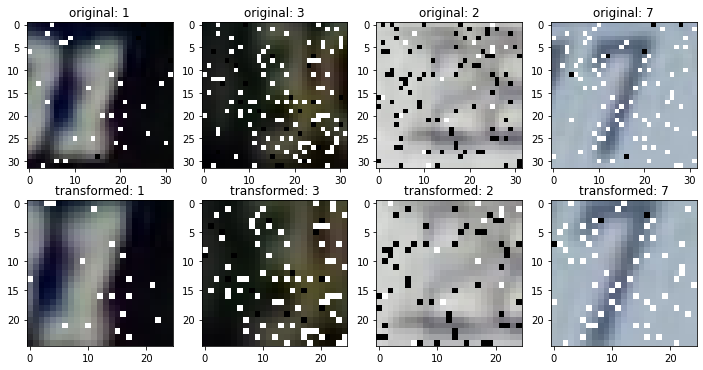

In [16]:
crop = [T.CenterCrop(size=25)(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(crop):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

### ColorJitter

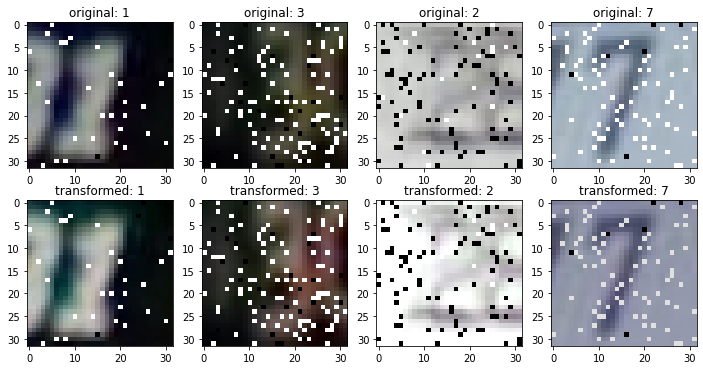

In [18]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitter_imgs = [jitter(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(jitter_imgs):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

Let's find $\mu$ and $\sigma$ to normalize

In [17]:
def get_mean_and_std(loader: DataLoader):
    mean = 0.0
    std = 0.0
    img_count = 0
    for images, _ in loader:
        batch_img_count = images.size(0)
        images = images.view(batch_img_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        img_count += batch_img_count
    return mean / img_count, std / img_count

In [19]:
mean, std = get_mean_and_std(analysis_dataloader)
print(f"mean = {mean}, std = {std}")

mean = tensor([0.4494, 0.4521, 0.4725]), std = tensor([0.2040, 0.2067, 0.1984])


Normalizing works good, in most cases dights became more distinct

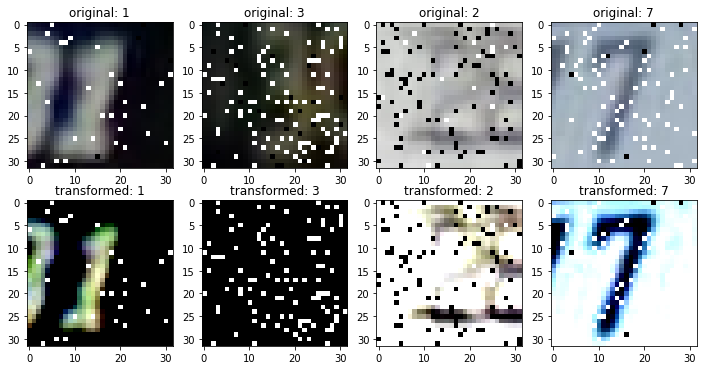

In [20]:
norm = T.Normalize(torch.Tensor(mean), torch.Tensor(std))
normed_imgs = [norm(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(normed_imgs):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

### Random rotation by moderate degree might help because some pictures were taken from ideal angle

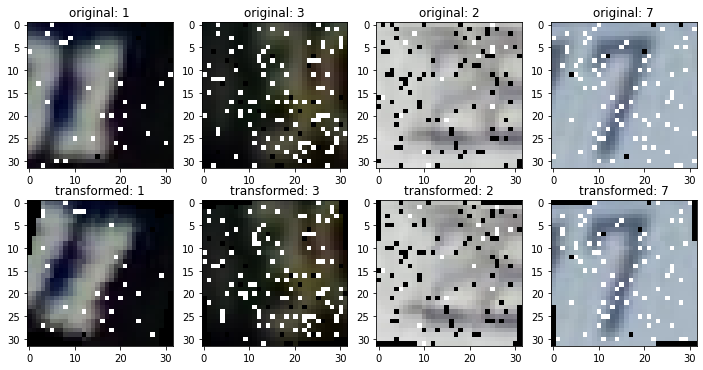

In [21]:
rotater = T.RandomRotation(degrees=(-15, 15))
rotated_imgs = [rotater(data[i][0]) for i in range(4)]

figure = plt.figure(figsize=(12, 12))
for i, img in enumerate(rotated_imgs):
    figure.add_subplot(1, 4, i+1)
    plt.title("transformed: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))
    
for i in range(4):
    figure.add_subplot(2, 4, i+1)
    plt.title("original: " + str(data[i][1]))
    plt.imshow(torch.moveaxis(data[i][0].squeeze(), 0, 2))

### Next transforms will be applied

- blurring
- normalizing
- rotating

In [22]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=Compose([
        ToTensor(),
        T.Lambda(remove_noise),
        T.CenterCrop(size=28),
        T.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    ]),
)

28

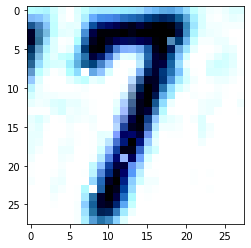

In [44]:
plt.imshow(torch.moveaxis(data[3][0].squeeze(), 0, 2))
len(data[3][0][0])

We randomly split the dataset into training and validation. <br>
In the first part, we will train the classification model. <br>
In the second part, we will evaluate the quality during the experiments. <br>

In [24]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

Data loaders initialization.

In [25]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Let's see what size batches the data loader produces.

In [26]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 28, 28])
Shape of y:  torch.Size([32]) torch.uint8


### Classification model

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


We set the architecture of the classification model. <br>
There is a lot of room for different experiments. <br>

In [ ]:
class BottleNeck(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        
    def forward(self, input):
        return self.layers(input)

In [46]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=1*6, kernel_size=3)) # in_channels=1 for gray scale
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size=2)) # 6x13x13
        
        self.layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size=3)) # 16x11x11
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size=2)) # 16x5x5
        
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(16*5*5, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

We send the model to the selected device.

In [47]:
model = CNN()
model.to(device)
print(model)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=400, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)


### Training

We set the loss function (optimization goal) and the optimizer.

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Code for visualizing the learning process.

Every `interval` optimization steps and at the end of epochs, we write the values of the loss function and metrics to the log. <br>
Then, by calling the `show_progress` function, we update the training schedule. <br>

In [49]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [50]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [51]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [52]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

Training loop.

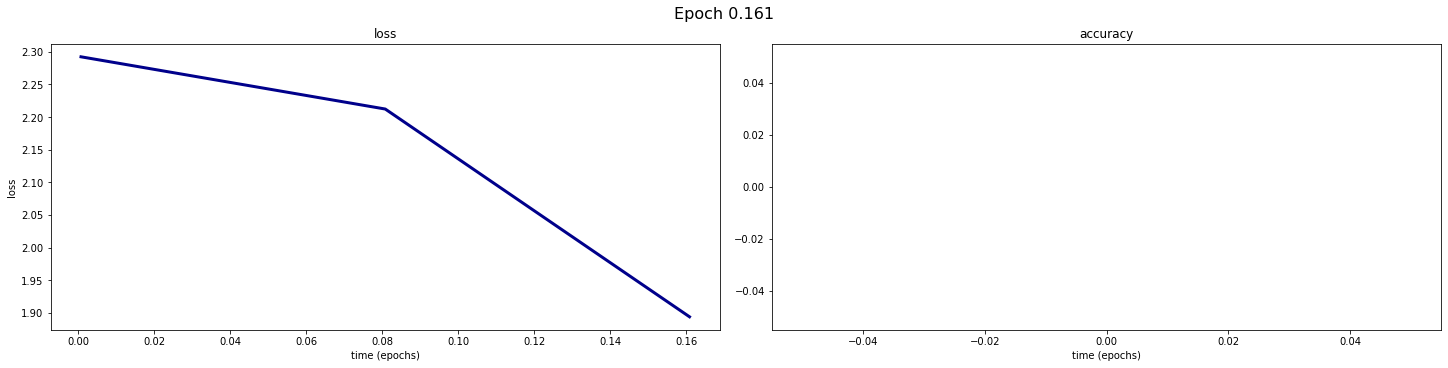

In [ ]:
epochs = 10
for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### Submit solution

Download the test part of the dataset.

In [ ]:
test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=Compose([
        #T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        ToTensor(),
        T.Normalize(torch.Tensor(mean), torch.Tensor(std)),
        #T.RandomRotation(degrees=(-15, 15))
    ]),
)

In [ ]:
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

We make predictions by the final model.

In [ ]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

In [ ]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            
write_solution('solution1.csv', predictions)